# Telecom Churn Analysis


**Introduction:**


Customer churn prediction is a critical task for businesses, particularly in the competitive telecom industry, where retaining customers is often more cost-effective than acquiring new ones. Interconnect Telecom, a service provider offering landline and internet services, seeks to forecast customer churn to proactively engage with at-risk customers through targeted promotions and customized offers.

This project aims to develop a predictive model for churn analysis using customer data, including personal demographics, service usage, contract details, and payment history. By identifying patterns and trends in customer behavior, the model will enable Interconnect to reduce churn rates and enhance customer retention strategies.

The primary focus of this analysis is on:

Understanding the features influencing customer churn.
Developing a robust machine learning model to predict churn.
Evaluating the model's performance using key metrics, primarily AUC-ROC and accuracy.
The insights gained from this project will empower Interconnect Telecom to make data-driven decisions and improve their customer experience.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Data Exploration and Cleaning

**Objective:** 

Gain a comprehensive understanding of the data and prepare it for modeling.

**Steps:**

* Load all datasets (contract.csv, personal.csv, internet.csv, and phone.csv) and inspect their structure using .head(), .info(), and .describe().
* Identify and handle missing values, ensuring consistency across all datasets.
* Standardize data types (e.g., converting TotalCharges from object to float).
* Explore categorical columns and encode them if necessary.

In [2]:
# Load datasets
df_contract = pd.read_csv("/datasets/final_provider/contract.csv")
df_personal = pd.read_csv("/datasets/final_provider/personal.csv")
df_internet = pd.read_csv("/datasets/final_provider/internet.csv")
df_phone = pd.read_csv("/datasets/final_provider/phone.csv")

###  Contract Data

In [3]:
df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [4]:
df_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [5]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


**Interpretation**

- BeginDate and EndDate are stored as strings but should be converted to datetime for proper analysis.
- TotalCharges is stored as an object, which is incorrect. It should be converted to float after handling any anomalies or missing values.

#### Convert Data Types

In [6]:
# converting the BeginDate and EndDate to datetime type and TotalCharges to float type

df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')


In [7]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


#### Handling missing values

In [8]:
df_contract.isna().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

**TotalCharges:**

Contains 11 missing values. This feature is numeric, representing the total charges paid by customers.


**EndDate:**

Contains 5174 missing values, accounting for 73% of the dataset.
These missing values correspond to active customers who have not churned yet.


1. TotalCharges:

Since TotalCharges is derived from the total payments a customer has made, the missing values could occur due to data entry errors or new customers with no charges yet.

Steps:
- Check if the missing rows in TotalCharges have valid MonthlyCharges and BeginDate.
- For customers with valid MonthlyCharges and BeginDate, approximate TotalCharges as:

TotalCharges = monthlyCharges * EstimatedDuration

- Use the difference between today’s date and BeginDate to estimate duration for active customers.
- Fill any remaining missing values with the median or mean of TotalCharges.

In [9]:
df_contract[df_contract["TotalCharges"].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


In [10]:
# Convert BeginDate to datetime
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], errors='coerce')

# Define today's date
today = datetime.today()

# Calculate estimated duration (in months) for rows with missing TotalCharges
def calculate_duration(begin_date):
    return (today.year - begin_date.year) * 12 + (today.month - begin_date.month)

# Fill missing TotalCharges for active customers
missing_totalcharges = df_contract['TotalCharges'].isna()
df_contract.loc[missing_totalcharges, 'TotalCharges'] = (
    df_contract.loc[missing_totalcharges].apply(
        lambda row: row['MonthlyCharges'] * calculate_duration(row['BeginDate']), axis=1
    )
)


# Fill any remaining missing values with the median of TotalCharges
df_contract['TotalCharges'].fillna(df_contract['TotalCharges'].median(), inplace=True)

**Duration Calculation:**

For each row, we calculate the months since the BeginDate until today.
This method ensures we accurately estimate the duration for active customers.

Multiplication:

Multiply the MonthlyCharges by the estimated duration to approximate TotalCharges.
Handle Remaining Missing Values:

If any missing values remain (e.g., invalid BeginDate), we replace them with the median of the TotalCharges column.

In [11]:
df_contract["TotalCharges"].isna().sum()

0

NO missing values.

 EndDate:
 
- The missing values in EndDate indicate customers who are still active and have not churned.

Steps:

- Replace missing EndDate values with a placeholder date (e.g., today’s date) for analysis.

Create a binary target column (Churn) where:
- 1 for customers with a valid EndDate (churned).
- 0 for customers with a missing EndDate (active).
- Retain EndDate for potential feature engineering (e.g., contract duration).

In [12]:
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')
df_contract['EndDate'].fillna(today, inplace=True)
df_contract['Churn'] = (df_contract['EndDate'] != today).astype(int)

In [13]:
df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,2025-01-04 18:34:41.891827,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2025-01-04 18:34:41.891827,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00.000000,Month-to-month,Yes,Mailed check,53.85,108.15,1


#### Duplicates handling

In [14]:
df_contract.duplicated().sum()

0

No duplicates found .

### Personal Data

In [15]:
df_personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


Columns like Partner and Dependents should ideally be represented as binary values (0 or 1) instead of strings (Yes/No).

In [16]:
df_personal['Partner'] = (df_personal['Partner'] == 'Yes').astype(int)
df_personal['Dependents'] = (df_personal['Dependents'] == 'Yes').astype(int)


gender Column:

- gender is categorical and might need encoding for machine learning models.

Solution: Use one-hot encoding or binary encoding depending on the model requirements.

In [17]:
df_personal['gender'] = (df_personal['gender'] == 'Female').astype(int)  # Female=1, Male=0


In [18]:
df_personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,1,0,1,0
1,5575-GNVDE,0,0,0,0
2,3668-QPYBK,0,0,0,0


In [19]:
df_personal.describe()

,gender,SeniorCitizen,Partner,Dependents
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.495244,0.162147,0.483033,0.299588
std,0.500013,0.368612,0.499748,0.458110
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000



SeniorCitizen:

- Mean: ~16% of the customers are senior citizens.

- Standard deviation suggests the data is heavily skewed towards non-senior citizens.


In [20]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   int64 
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   int64 
 4   Dependents     7043 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 275.2+ KB


No missing values across all columns.

**Key Insights**


Senior Citizens:

- Only ~16% of the customers are senior citizens, indicating a majority younger customer base.

Partner and Dependents:

 These features can help identify whether family-related factors influence churn. For instance:
- Customers with partners might have longer retention.
- Customers with dependents might prioritize stable services.


Gender:

- The gender column might reveal insights when combined with churn or other contract-related features.

### internet Data 

In [21]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [22]:
df_internet["InternetService"].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [23]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,8496-DMZUK,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [24]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Encode Binary Columns:**

- Convert Yes/No columns to binary values (1 for Yes, 0 for No) for easier analysis.

In [25]:
binary_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
               'TechSupport', 'StreamingTV', 'StreamingMovies']
df_internet[binary_cols] = df_internet[binary_cols].apply(lambda x: (x == 'Yes').astype(int))


Convert InternetService to Categorical:

- Use one-hot encoding or label encoding for the InternetService column.

In [26]:
df_internet = pd.get_dummies(df_internet, columns=["InternetService"], drop_first=True)

# Check the resulting columns
df_internet.head()

,customerID,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetService_Fiber optic
0,7590-VHVEG,0,1,0,0,0,0,0
1,5575-GNVDE,1,0,1,0,0,0,0
2,3668-QPYBK,1,1,0,0,0,0,0
3,7795-CFOCW,1,0,1,1,0,0,0
4,9237-HQITU,0,0,0,0,0,0,1


In [27]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   customerID                   5517 non-null   object
 1   OnlineSecurity               5517 non-null   int64 
 2   OnlineBackup                 5517 non-null   int64 
 3   DeviceProtection             5517 non-null   int64 
 4   TechSupport                  5517 non-null   int64 
 5   StreamingTV                  5517 non-null   int64 
 6   StreamingMovies              5517 non-null   int64 
 7   InternetService_Fiber optic  5517 non-null   uint8 
dtypes: int64(6), object(1), uint8(1)
memory usage: 307.2+ KB


In [28]:
#Checking the percentage of customers using each type of service.

df_internet[binary_cols].mean() * 100


OnlineSecurity      36.595976
OnlineBackup        44.027551
DeviceProtection    43.900671
TechSupport         37.049121
StreamingTV         49.066522
StreamingMovies     49.519666
dtype: float64

**Most Popular Services:**

- StreamingTV and StreamingMovies are the most used services, with nearly half of the customers opting for them (49.07% and 49.52%, respectively). This indicates that entertainment services are a key offering for the internet provider.


**Moderately Used Services:**

- OnlineBackup and DeviceProtection have similar usage rates, with approximately 44% of customers using these services. This suggests a moderate interest in data security and device protection services.


**Least Popular Services:**

- TechSupport and OnlineSecurity are the least used services, with adoption rates of 37.05% and 36.60%, respectively. This could indicate a lack of perceived value in these services or a gap in customer awareness about their benefits.


**General Trends:**

- A significant proportion of customers (over 50%) do not use any additional services beyond basic internet. This suggests potential upselling opportunities for the internet provider.

### phone Data

In [29]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [30]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [31]:
df_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5301-GAUUY,No
freq,1,3390


The dataset df_phone contains two columns: customerID and MultipleLines. Here's an analysis of the data:

Data Structure:

- The customerID column contains 6361 unique entries, with no missing values. It appears to be an identifier.
- The MultipleLines column has only two unique values: "Yes" and "No." This column indicates whether the customer has multiple lines, with "No" being the most frequent (3390 occurrences) and "Yes" less frequent (2971 occurrences).

Potential Issues:

- Categorical Encoding: The MultipleLines column is a categorical variable stored as a string (object dtype). If you intend to use this data for modeling, it needs to be converted into a numerical format (e.g., using one-hot encoding or label encoding).
- CustomerID Usage: The customerID column is a unique identifier, which may not be relevant for analysis or prediction models directly, as it's likely non-informative for the model's performance.

**Handle the MultipleLines column:**


- Label Encoding: Convert "Yes" and "No" to numerical values (e.g., 1 for "Yes" and 0 for "No").
- One-Hot Encoding: Create binary columns indicating whether a customer has multiple lines.

In [32]:
# Convert 'MultipleLines' to numeric using Label Encoding
df_phone['MultipleLines'] = df_phone['MultipleLines'].map({'No': 0, 'Yes': 1})


In [33]:
df_phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0


####  Merge datasets

In [34]:
# Merge datasets
merged_df = df_contract.merge(df_personal, on="customerID", how="left")
merged_df = merged_df.merge(df_internet, on="customerID", how="left")
merged_df = merged_df.merge(df_phone, on="customerID", how="left")

#### Drop unnecessary features

In [35]:
# Drop columns not needed for modeling
merged_df.drop(columns=['customerID', 'BeginDate', 'EndDate'], inplace=True)

#### Find missing values

In [36]:
# Check for missing values
missing_values = merged_df.isnull().sum()
missing_values


Type                              0
PaperlessBilling                  0
PaymentMethod                     0
MonthlyCharges                    0
TotalCharges                      0
Churn                             0
gender                            0
SeniorCitizen                     0
Partner                           0
Dependents                        0
OnlineSecurity                 1526
OnlineBackup                   1526
DeviceProtection               1526
TechSupport                    1526
StreamingTV                    1526
StreamingMovies                1526
InternetService_Fiber optic    1526
MultipleLines                   682
dtype: int64

**Handling Categorical Features:**

- Impute Missing Values with a New Category ("Unknown")
- Since these are categorical features, you can create a new category to represent missing values (e.g., Unknown or Not Applicable). This approach is suitable if the missingness is systematic (e.g., customers not using a certain service).

In [37]:
# Replace missing values with 'Unknown'
cols_to_impute = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                  'StreamingTV', 'StreamingMovies', 'InternetService_Fiber optic', 'MultipleLines']
#merged_df[cols_to_impute] = merged_df[cols_to_impute].fillna('Unknown')


for col in cols_to_impute:
    merged_df[col] = merged_df[col].fillna(merged_df[col].mode()[0])

In [38]:
# Check for missing values
missing_values = merged_df.isnull().sum()
missing_values


Type                           0
PaperlessBilling               0
PaymentMethod                  0
MonthlyCharges                 0
TotalCharges                   0
Churn                          0
gender                         0
SeniorCitizen                  0
Partner                        0
Dependents                     0
OnlineSecurity                 0
OnlineBackup                   0
DeviceProtection               0
TechSupport                    0
StreamingTV                    0
StreamingMovies                0
InternetService_Fiber optic    0
MultipleLines                  0
dtype: int64

#### Distribution of Numerical Features:

MonthlyCharges:

- Check how the charges vary and if they have any relationship with churn.

- Create a histogram or box plot to see the distribution and any potential differences between customers who churn vs those who don't.


TotalCharges: 

- This can be similarly analyzed, as it represents the cumulative charges. It may have skewness or outliers that could affect churn.

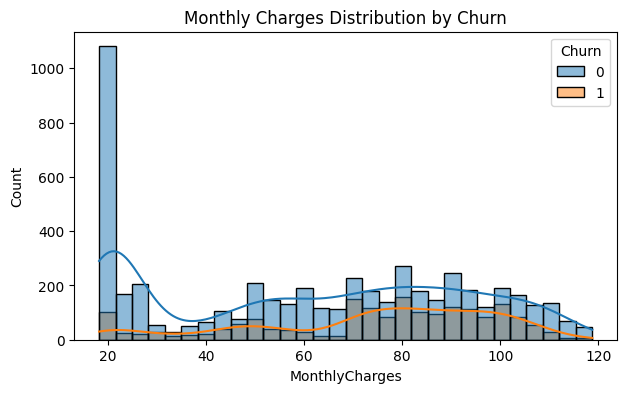

In [39]:

# Plot histograms for numerical features
plt.figure(figsize=(7, 4))
sns.histplot(data=merged_df, x='MonthlyCharges', hue='Churn', kde=True, bins=30)
plt.title('Monthly Charges Distribution by Churn')
plt.show()



**Observations:**


The image presents two histograms, both exploring the relationship between customer churn and different billing aspects. 

Monthly Charges Distribution by Churn: 

This histogram shows how monthly charges are distributed among customers who churned (orange) and those who didn't (blue). 
The majority of customers who didn't churn fall within the lower monthly charge range, while churned customers are more evenly distributed across the different charge levels. 

This suggests that higher monthly charges could be a contributing factor to customer churn. 

Total Charges Distribution by Churn: 


This histogram illustrates the distribution of total charges for churned and non-churned customers. 
Non-churned customers tend to have lower total charges, indicating that they might be newer customers or have shorter subscription periods. 
Churned customers, on the other hand, have a wider range of total charges, implying that they might have been long-term customers who eventually decided to leave. 


Overall Interpretation: 


Both graphs suggest a correlation between higher charges and customer churn. 
This information can be valuable for businesses as it highlights the importance of competitive pricing strategies and customer retention efforts, especially for customers with higher monthly bills or longer tenure.

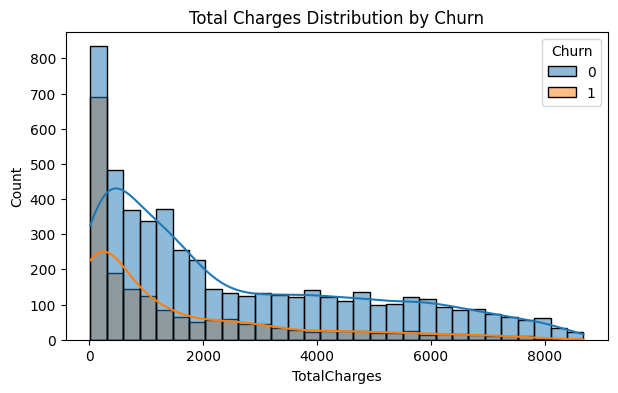

In [40]:
plt.figure(figsize=(7, 4))
sns.histplot(data=merged_df, x='TotalCharges', hue='Churn', kde=True, bins=30)
plt.title('Total Charges Distribution by Churn')
plt.show()

**Observations:**

The graph illustrates the distribution of total charges for customers, categorized by whether they churned (left the service) or not. 


Key Points: 

- X-axis: Represents the total charges incurred by customers. 
- Y-axis: Shows the count of customers falling into each total charge range. 

Blue Bars: Depict customers who did not churn. 
Orange Bars: Represent customers who churned. 

Curves: The lines superimposed on the bars represent the kernel density estimate (KDE), which helps to visualize the overall shape of the distribution. 


Interpretation: 


Churn and Total Charges:


The graph suggests a relationship between the total charges and customer churn. Customers with lower total charges are more likely to churn. This could indicate that newer customers are more likely to leave the service, or that customers who spend less are less invested in the service and therefore more likely to switch. 


Higher Charges, Lower Churn:
Conversely, customers with higher total charges are less likely to churn, indicating that customers who have spent more with the company are more likely to stay loyal. 


Peak Churn:
The peak churn rate occurs around the lower total charges, suggesting that there may be an issue with customer retention early in the customer lifecycle.


#### Examine Categorical Variables:


- PaymentMethod, InternetService, Type: Create bar charts for these features against churn to see if there are significant differences in the proportions of customers who churn for each category.

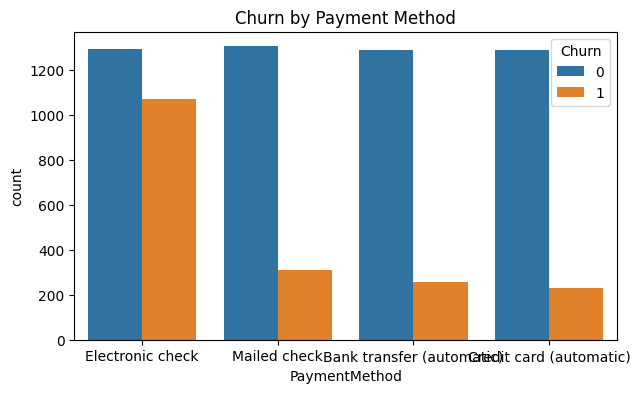

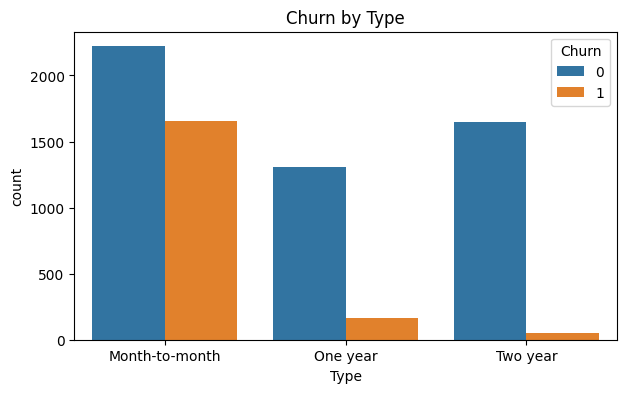

In [41]:
# Bar plots for categorical features
plt.figure(figsize=(7, 4))
sns.countplot(data=merged_df, x='PaymentMethod', hue='Churn')
plt.title('Churn by Payment Method')
plt.show()

plt.figure(figsize=(7, 4))
sns.countplot(data=merged_df, x='Type', hue='Churn')
plt.title('Churn by Type')
plt.show()


**Observations:**

**Churn by Payment Method:** 

This graph shows the count of customers who churned (Churn = 1) and those who didn't (Churn = 0) for different payment methods.


Key Observations:

- Electronic check and mailed check have the highest churn rates. 
- Bank transfer (automatic) and credit card (automatic) have lower churn rates. 
- This suggests that automatic payment methods might be associated with lower churn.


**Churn by Type:** 

- This graph shows the churn count for different customer types. 

Key Observations:


- The customer type labeled "0" has a higher churn count compared to the type labeled "1." 
- This suggests that the customer type "0" might require more attention to reduce churn.


Overall Interpretation: 


- The graphs indicate a relationship between payment method and churn, as well as customer type and churn. 
- Businesses can use this information to identify areas for improvement and focus on customer retention strategies. 
- For example, they might offer incentives for using automatic payment methods or tailor retention strategies for the customer type with higher churn rates.


#### Multicollinearity Check:


- Use a correlation matrix and heatmap to assess the relationships between numerical features.
- You can also run a Variance Inflation Factor (VIF) test to measure multicollinearity and remove highly correlated features if necessary.

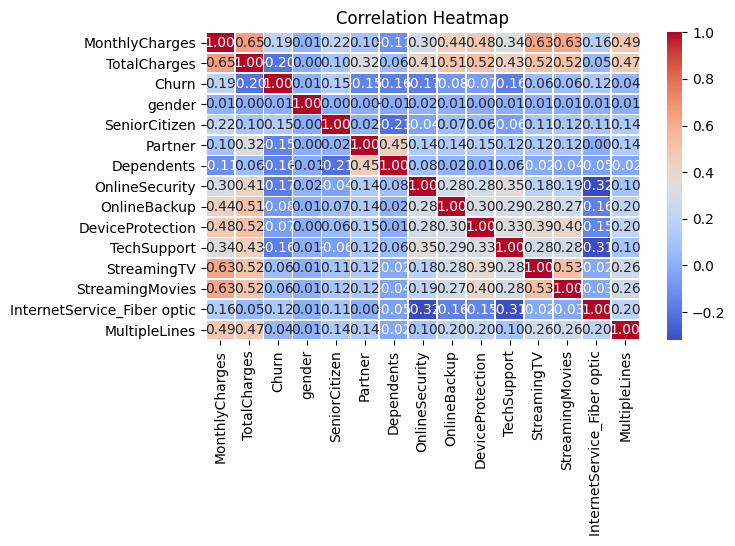

         Variable       VIF
0           const  5.900915
1  MonthlyCharges  1.735119
2    TotalCharges  1.735119


In [42]:


# Correlation heatmap
corr_matrix = merged_df.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Check VIF (Variance Inflation Factor) for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# VIF Calculation
X = merged_df[['MonthlyCharges', 'TotalCharges']]  # Example features
X = add_constant(X)  # Add constant for intercept
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


**Observations:**

This is a correlation heatmap, which visualizes the relationships between different variables in a dataset. Here's how to interpret it.

Colors: The colors represent the strength and direction of the correlation between two variables.
- Dark red: Strong positive correlation (variables move in the same direction) 
- Dark blue: Strong negative correlation (variables move in opposite directions) 
- White: No correlation 
- Values: The numbers in each cell represent the correlation coefficient, which ranges from -1 to 1. 

- 1: Perfect positive correlation, -1: Perfect negative correlation, and 0: No correlation. 

Key observations from this heatmap: 


Strong positive correlation:

- MonthlyCharges and TotalCharges have a strong positive correlation (0.65), indicating that higher monthly charges lead to higher total charges. 

Moderate negative correlation:

- Churn and TotalCharges have a moderate negative correlation (-0.20), suggesting that customers with higher total charges are less likely to churn. 

Weak correlations:

- Most other variables show weak correlations, implying that they don't have a strong influence on each other. 

No correlation:
- gender and SeniorCitizen have almost no correlation (0.01)


### Data Preprocessing for Modeling

**Split the Data**

Splitting your dataset into training, validation, and test sets ensures that the model is trained and evaluated effectively.

In [43]:
# Define features (X) and target variable (y)
X = merged_df.drop('Churn', axis=1)  # Drop the target column
y = merged_df['Churn']  # Target column

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Check the distribution
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (4930, 17)
Validation set: (1056, 17)
Test set: (1057, 17)


**Scale Numerical Features**

Standardizing numerical features helps models converge faster and improves performance.

In [44]:
# Select numerical features
numerical_features = ['MonthlyCharges', 'TotalCharges'] 

# Initialize the scaler
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])


 **Encoding Categorical Features with One-Hot Encoding**

Select Categorical Features


Purpose: Identify which columns in the dataset are categorical and need encoding. In this case, we are dealing with customer data for a telecom company, so features related to customer plans and services are selected.

In [45]:


# Select categorical features
categorical_features = ['PaperlessBilling','PaymentMethod', 'Type', 'OnlineSecurity', 'OnlineBackup', 
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


# Convert categorical columns to string
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_val[categorical_features] = X_val[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)


# Initialize the encoder
encoder = OneHotEncoder(drop='first', sparse=False)

# Fit and transform on training data
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_val_encoded = encoder.transform(X_val[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

# Convert encoded arrays to DataFrame
encoded_cols = encoder.get_feature_names(categorical_features)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_cols, index=X_val.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# Drop original categorical columns and concatenate encoded columns
X_train = pd.concat([X_train.drop(categorical_features, axis=1), X_train_encoded_df], axis=1)
X_val = pd.concat([X_val.drop(categorical_features, axis=1), X_val_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(categorical_features, axis=1), X_test_encoded_df], axis=1)


/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Training Model

In [46]:

# Initialize models
log_reg = LogisticRegression(  penalty='l2',
    C=0.5,  # Default is 1.0; try smaller values for stronger regularization
    class_weight='balanced',
    random_state=42)

dec_tree = DecisionTreeClassifier(   max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    criterion='entropy',
    random_state=42,
    class_weight='balanced')

# Train models
log_reg.fit(X_train, y_train)
dec_tree.fit(X_train, y_train)

# Make predictions
log_reg_preds = log_reg.predict_proba(X_val)[:, 1]
dec_tree_preds = dec_tree.predict_proba(X_val)[:, 1]

# Evaluate
log_reg_auc = roc_auc_score(y_val, log_reg_preds)
dec_tree_auc = roc_auc_score(y_val, dec_tree_preds)

log_reg_acc = accuracy_score(y_val, log_reg.predict(X_val))
dec_tree_acc = accuracy_score(y_val, dec_tree.predict(X_val))

print(f"Logistic Regression - AUC-ROC: {log_reg_auc:.3f}, Accuracy: {log_reg_acc:.3f}")
print(f"Decision Tree - AUC-ROC: {dec_tree_auc:.3f}, Accuracy: {dec_tree_acc:.3f}")


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - AUC-ROC: 0.827, Accuracy: 0.726
Decision Tree - AUC-ROC: 0.772, Accuracy: 0.706


**Observations:**

Baseline Results:

Logistic Regression:

AUC-ROC: 0.827
Accuracy: 0.726


Decision Tree:

AUC-ROC: 0.772
Accuracy: 0.706

The Logistic Regression model performed better with a higher AUC-ROC and accuracy compared to the Decision Tree model, but both still leave room for improvement.

## Advanced Models (Random Forest & XGBoost)

In [47]:


# Initialize models
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train models
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Make predictions
rf_preds = rf.predict_proba(X_val)[:, 1]
xgb_preds = xgb.predict_proba(X_val)[:, 1]

# Evaluate
rf_auc = roc_auc_score(y_val, rf_preds)
xgb_auc = roc_auc_score(y_val, xgb_preds)

rf_acc = accuracy_score(y_val, rf.predict(X_val))
xgb_acc = accuracy_score(y_val, xgb.predict(X_val))

print(f"Random Forest - AUC-ROC: {rf_auc:.3f}, Accuracy: {rf_acc:.3f}")
print(f"XGBoost - AUC-ROC: {xgb_auc:.3f}, Accuracy: {xgb_acc:.3f}")


Random Forest - AUC-ROC: 0.814, Accuracy: 0.784
XGBoost - AUC-ROC: 0.819, Accuracy: 0.774


**Observations:**
    
Advanced Model Results:

Random Forest:

AUC-ROC: 0.814
Accuracy: 0.784


XGBoost:

AUC-ROC: 0.819
Accuracy: 0.774

Here, XGBoost performed slightly better than Random Forest, with both models showing substantial improvements over the baseline models.

### Hyperparameter Tuning for Random Forest

To further improve the performance of Random Forest, we perform hyperparameter tuning using GridSearchCV.

Parameters Tuning:

n_estimators: [100, 200, 250]

max_depth: [10, 20, None]

min_samples_split: [2, 5, 10]

min_samples_leaf: [1, 2, 4]

In [48]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 250],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=43), param_grid, cv=5, scoring='roc_auc')
grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=43),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 250]},
             scoring='roc_auc')

In [49]:
# Make predictions
rf_preds = grid_rf.predict_proba(X_val)[:, 1]

# Evaluate
rf_auc = roc_auc_score(y_val, rf_preds)
rf_acc = accuracy_score(y_val, grid_rf.predict(X_val))

print(f"Random Forest - AUC-ROC: {rf_auc:.3f}, Accuracy: {rf_acc:.3f}")



Random Forest - AUC-ROC: 0.841, Accuracy: 0.803


**Observations:**


GridSearchCV Random Forest Results:

AUC-ROC: 0.841
Accuracy: 0.803

The tuned Random Forest model achieved the best AUC-ROC score of all the models, as well as the highest accuracy.

## Final Test Model

In [50]:
# Make predictions on the test set using the tuned Random Forest model (best model)
rf_test_preds = grid_rf.predict_proba(X_test)[:, 1]  # Get probabilities for AUC-ROC calculation

# Evaluate the model on the test set
rf_test_auc = roc_auc_score(y_test, rf_test_preds)
rf_test_acc = accuracy_score(y_test, grid_rf.predict(X_test))

# Print the results
print(f"Tuned Random Forest - Test AUC-ROC: {rf_test_auc:.3f}, Test Accuracy: {rf_test_acc:.3f}")


Tuned Random Forest - Test AUC-ROC: 0.842, Test Accuracy: 0.798


**Observations:**
    
    
Test AUC-ROC: 0.842:

This indicates that the tuned Random Forest model performs very well in distinguishing between the churn and non-churn classes. An AUC-ROC value of 0.842 suggests that the model has a strong ability to rank churn probabilities correctly, with a high true positive rate and low false positive rate.


Test Accuracy: 0.798:

The accuracy of 79.8% on the test set indicates that the model correctly predicted the churn status for nearly 80% of the instances. While accuracy is a useful metric, it may not fully reflect model performance on imbalanced data, so the AUC-ROC is a better evaluation of model discrimination.




###  Final Conclusion

The tuned Random Forest model has delivered strong results on both the AUC-ROC and accuracy metrics. It shows good generalization to the test set and successfully differentiates between churn and non-churn instances.

Since the AUC-ROC is above 0.80, it suggests that the model is highly capable, making it an ideal choice for your final model.